In [1]:
import json
import tensorflow as tf
from tensorflow.keras.metrics import AUC
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import random
import os

from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/Radiology/subset.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/processed/Normal/masks/Normal-5764.png  
  inflating: data/processed/Normal/masks/Normal-5868.png  
  inflating: data/processed/Normal/masks/Normal-5869.png  
  inflating: data/processed/Normal/masks/Normal-587.png  
  inflating: data/processed/Normal/masks/Normal-5870.png  
  inflating: data/processed/Normal/masks/Normal-5871.png  
  inflating: data/processed/Normal/masks/Normal-5872.png  
  inflating: data/processed/Normal/masks/Normal-5873.png  
  inflating: data/processed/Normal/masks/Normal-5874.png  
  inflating: data/processed/Normal/masks/Normal-5875.png  
  inflating: data/processed/Normal/masks/Normal-5876.png  
  inflating: data/processed/Normal/masks/Normal-5877.png  
  inflating: data/processed/Normal/masks/Normal-5878.png  
  inflating: data/processed/Normal/masks/Normal-5879.png  
  inflating: data/processed/Normal/masks/Normal-588.png  
  inflating: data/processed/Normal/masks/Normal-5880.png  
  infla

## Loading data

In [3]:
import json

with open("index.json") as f:
    records = json.load(f)

print(len(records))
label_map = {
    "COVID" : 1.0,
    "Normal" : 0.0
}

random.shuffle(records)

split_idx = int(len(records) * (1 - 0.2))

train_records = records[:split_idx]
temp = records[split_idx:]

test_split_idx = int(len(temp) * (1 - 0.5))

val_records = temp[:test_split_idx]
test_records = temp[test_split_idx:]


13808


## Helper functions for train/validation dataset generator

In [4]:
def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels = 3)
    img = tf.image.resize(img, (224, 224))
    img = tf.cast(img, tf.float32) / 225.0

    return img, label

In [5]:
def build_dataset(recs, training):
    paths = [os.path.join(r["image_path"]) for r in recs]
    labels = [label_map[r["label"]] for r in recs]

    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(load_image, num_parallel_calls = tf.data.AUTOTUNE)

    if training:
        ds.shuffle(512)

    ds = ds.batch(32).prefetch(tf.data.AUTOTUNE)

    return ds

## Train and Validation Datasets

In [6]:
train_ds = build_dataset(train_records, True)
val_ds = build_dataset(val_records, False)

## Load base model

In [7]:
base_model = EfficientNetB0(
    include_top = False,
    weights = "imagenet",
    input_shape = (224, 224, 3)
)
base_model.trainable = False

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Top of the model

In [8]:
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
output = layers.Dense(1, activation = "sigmoid")(x)

model = models.Model(inputs = base_model.input, outputs = output)

## Model compilation

In [9]:
model.compile(
    optimizer = Adam(learning_rate = 1e-4),
    metrics = [AUC(name = "auc")],
    loss = "binary_crossentropy"
)

In [10]:
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 5
)

Epoch 1/5
346/346 ━━━━━━━━━━━━━━━━━━━━ 79s 148ms/step - auc: 0.5016 - loss: 0.5897 - val_auc: 0.5000 - val_loss: 0.5727
Epoch 2/5
346/346 ━━━━━━━━━━━━━━━━━━━━ 18s 53ms/step - auc: 0.5003 - loss: 0.5765 - val_auc: 0.5000 - val_loss: 0.5726
Epoch 3/5
346/346 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - auc: 0.4971 - loss: 0.5769 - val_auc: 0.5034 - val_loss: 0.5728
Epoch 4/5
346/346 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step - auc: 0.5015 - loss: 0.5762 - val_auc: 0.5000 - val_loss: 0.5729
Epoch 5/5
346/346 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - auc: 0.5082 - loss: 0.5760 - val_auc: 0.5000 - val_loss: 0.5729


In [11]:
base_model.trainable = True

for layer in base_model.layers[:-40]:
    layer.trainable = False


In [12]:
model.compile(
    optimizer = Adam(learning_rate=1e-5),
    loss = "binary_crossentropy",
    metrics = [AUC(name="auc")]
)

In [13]:
history_ft = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)

Epoch 1/5
346/346 ━━━━━━━━━━━━━━━━━━━━ 87s 131ms/step - auc: 0.5123 - loss: 0.5953 - val_auc: 0.5390 - val_loss: 0.5795
Epoch 2/5
346/346 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - auc: 0.5109 - loss: 0.5774 - val_auc: 0.6839 - val_loss: 0.5698
Epoch 3/5
346/346 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step - auc: 0.5231 - loss: 0.5762 - val_auc: 0.7273 - val_loss: 0.5721
Epoch 4/5
346/346 ━━━━━━━━━━━━━━━━━━━━ 22s 60ms/step - auc: 0.5393 - loss: 0.5747 - val_auc: 0.7498 - val_loss: 0.5674
Epoch 5/5
346/346 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step - auc: 0.5459 - loss: 0.5737 - val_auc: 0.7621 - val_loss: 0.5670


In [14]:
y_true = []
y_pred = []

for x, y in val_ds:
    preds = model.predict(x, verbose=0)
    y_true.extend(y.numpy())
    y_pred.extend(preds.squeeze())

## Evaluating performance manually for actual numbers



In [15]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_true, y_pred)

best_idx = (tpr - fpr).argmax()
best_threshold = thresholds[best_idx]

best_threshold


np.float32(0.24099901)

In [16]:
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score,
    confusion_matrix
)
import numpy as np

auc = roc_auc_score(y_true, y_pred)

y_pred = np.array(y_pred)
y_pred_bin = (y_pred > 0.24099901).astype(int)

acc = accuracy_score(y_true, y_pred_bin)
prec = precision_score(y_true, y_pred_bin)
rec = recall_score(y_true, y_pred_bin)
cm = confusion_matrix(y_true, y_pred_bin)

print("AUC:", auc)
print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("Confusion Matrix:\n", cm)

AUC: 0.7725416338410364
Accuracy: 0.6958725561187545
Precision: 0.44844517184942717
Recall: 0.7675070028011205
Confusion Matrix:
 [[687 337]
 [ 83 274]]


### Testing on test dataset

In [17]:
y_true = []
y_pred = []
test_ds = build_dataset(test_records, False)

for x, y in test_ds:
    preds = model.predict(x, verbose=0)
    y_true.extend(y.numpy())
    y_pred.extend(preds.squeeze())

In [21]:
auc = roc_auc_score(y_true, y_pred)

y_pred = np.array(y_pred)
y_pred_bin = (y_pred > 0.23296885).astype(int)

acc = accuracy_score(y_true, y_pred_bin)
prec = precision_score(y_true, y_pred_bin)
rec = recall_score(y_true, y_pred_bin)
cm = confusion_matrix(y_true, y_pred_bin)

print("AUC:", auc)
print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("Confusion Matrix:\n", cm)

AUC: 0.7795459147244689
Accuracy: 0.38377986965966693
Precision: 0.3015741507870754
Recall: 0.978494623655914
Confusion Matrix:
 [[166 843]
 [  8 364]]


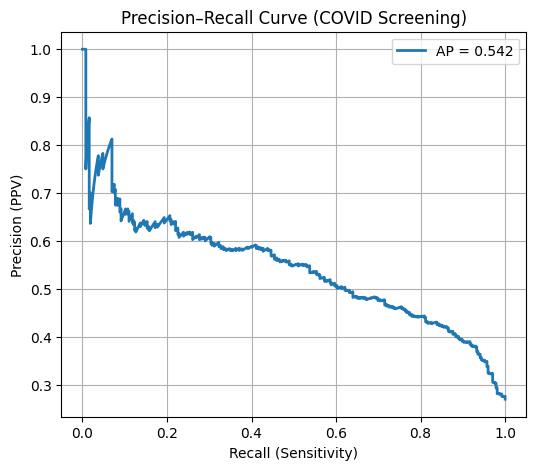

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, thresholds = precision_recall_curve(y_true, y_pred)

ap = average_precision_score(y_true, y_pred)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, linewidth=2, label=f"AP = {ap:.3f}")
plt.xlabel("Recall (Sensitivity)")
plt.ylabel("Precision (PPV)")
plt.title("Precision–Recall Curve (COVID Screening)")
plt.legend()
plt.grid(True)
plt.show()

In [24]:
target_recall = 0.90

# Find first threshold where recall >= target
idx = np.where(recall >= target_recall)[0][-1]

chosen_threshold = thresholds[idx]
chosen_precision = precision[idx]
chosen_recall = recall[idx]

print(f"Chosen threshold: {chosen_threshold:.3f}")
print(f"Precision at {target_recall*100:.0f}% recall: {chosen_precision:.3f}")
print(f"Recall: {chosen_recall:.3f}")

Chosen threshold: 0.238
Precision at 90% recall: 0.391
Recall: 0.901


In [25]:
operating_points = [0.95, 0.90, 0.85, 0.80]

print("Recall | Precision | Threshold")
print("-" * 32)

for r in operating_points:
    idx = np.where(recall >= r)[0][-1]
    print(f"{recall[idx]:.2f}   | {precision[idx]:.2f}      | {thresholds[idx]:.3f}")

Recall | Precision | Threshold
--------------------------------
0.95   | 0.35      | 0.236
0.90   | 0.39      | 0.238
0.85   | 0.42      | 0.239
0.80   | 0.44      | 0.240


After all analysis, because the dataset contains far more normal cases than COVID-19 cases, I evaluated the model using the Precision–Recall curve rather than accuracy alone. I selected an operating threshold of 0.238, which allows the model to correctly identify approximately 90% of COVID-19 cases, placing emphasis on sensitivity. At this threshold, the model achieves a precision of 39%, meaning that while some non-COVID cases are flagged, the risk of missing true COVID-19 cases is substantially reduced. This trade-off is appropriate for an early screening or triage setting, where false positives can be reviewed further, but false negatives are more critical.

In [27]:
model.save("efficient_net_classifier.keras")

In [28]:
from google.colab import files

files.download("efficient_net_classifier.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>